In [1]:
import networkx as nx

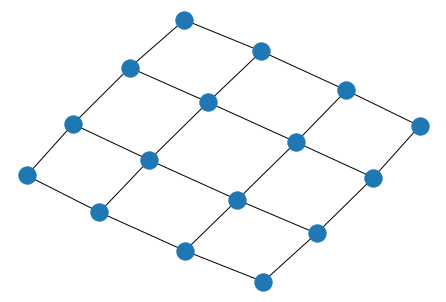

In [2]:
# Create a graph and visualize it
G = nx.grid_2d_graph(4,4)

import matplotlib.pyplot as plt
nx.draw(G)

In [3]:
import gurobipy as gp
from gurobipy import GRB

In [4]:
# Create model object
m = gp.Model()

# Create variable for each node
x = m.addVars( G.nodes, vtype=GRB.BINARY )

# Objective function: minimize number of nodes
m.setObjective( gp.quicksum( x[i] for i in G.nodes ), GRB.MINIMIZE )

# Add constraint for each node: N(i) is a vertex cut!
m.addConstrs( gp.quicksum( x[j] for j in G.neighbors(i) ) >= 1 for i in G.nodes )

m._G = G
m._x = x

m.update()

Academic license - for non-commercial use only - expires 2021-07-26
Using license file C:\Users\Austin\gurobi.lic


In [5]:
# Add (violated) cut constraints in a callback routine
def cut_callback(m, where):
    
    # check if LP relaxation at this BB node is integer
    if where == GRB.Callback.MIPSOL: 
        
        # retrieve the LP relaxation solution at this BB node
        xval = m.cbGetSolution(m._x)
        
        # which nodes are selected in the LP solution?
        chosen_nodes = [ i for i in m._G.nodes if xval[i] > 0.5 ]
        
        # if G[chosen_nodes] is not connected, then 
        #   find a minimal vertex cut C from V \ (chosen_nodes)
        #   and add constraint x(C) >= 1.
        
        if not nx.is_connected( G.subgraph( chosen_nodes ) ):
            
            not_chosen = [ i for i in m._G.nodes if xval[i] < 0.5 ]
            
            for i in not_chosen:
                
                chosen_nodes.append(i)
                
                if nx.is_connected( G.subgraph( chosen_nodes ) ):
                    chosen_nodes.pop()
                    
            C = [ i for i in m._G.nodes if i not in chosen_nodes ]    
            
            m.cbLazy( gp.quicksum( m._x[i] for i in C ) >= 1 )

In [6]:
# Tell Gurobi that we will be adding (lazy) constraints
m.Params.lazyConstraints = 1

# Designate the callback routine to be the function "cut_callback"
m._callback = cut_callback

# Solve the MIP with our callback
m.optimize(m._callback)

Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 16 rows, 16 columns and 48 nonzeros
Model fingerprint: 0xa81cd16d
Variable types: 0 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 8.0000000
Presolve removed 4 rows and 0 columns
Presolve time: 0.01s
Presolved: 12 rows, 16 columns, 32 nonzeros
Variable types: 0 continuous, 16 integer (16 binary)

Root relaxation: objective 6.000000e+00, 10 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.00000    0   12    8.00000    6.00000  

In [7]:
print("Objective:",m.objVal)

selected_nodes = [ i for i in G.nodes if x[i].x > 0.5 ]

Objective: 7.0


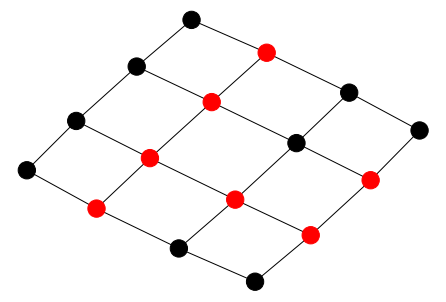

In [9]:
# Visualize the solution
node_colors = [ "red" if i in selected_nodes else "black" for i in G.nodes ]

nx.draw( G, node_color=node_colors )